In [1]:
import time
import json

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

/home/mudro/Documents/Projects/How-to-test-NN/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__)

BATCH_SIZE = 64

## transformations
transform = transforms.Compose([transforms.ToTensor()])

1.13.0+cu117


In [3]:
DATA_PATH = "./catsdogs/PetImages"

In [4]:
! ls

catsdogs  cats_vs_dogs.ipynb  magical-magic.gif  PXL_20221116_122829254.jpg


In [5]:
NORMALIZE_COEF = 0.5

In [6]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[NORMALIZE_COEF, NORMALIZE_COEF, NORMALIZE_COEF],
                         std=[NORMALIZE_COEF, NORMALIZE_COEF, NORMALIZE_COEF] )
])

In [7]:
data = torchvision.datasets.ImageFolder(root=DATA_PATH, transform=transform)

In [8]:
train_data, test_data, valid_data = torch.utils.data.random_split(data, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(42))

In [9]:
len(train_data), len(test_data), len(valid_data)

(19997, 2499, 2499)

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE,
                                           num_workers=4,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=BATCH_SIZE,
                                          num_workers=4,
                                          shuffle=False)
valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                          batch_size=BATCH_SIZE,
                                          num_workers=4,
                                          shuffle=False)

In [11]:
classes = {
    0: 'cat',
    1: 'dog'
}

In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
def imshow(img):
    npimg = (img.numpy() * NORMALIZE_COEF ) + NORMALIZE_COEF
    plt.imshow(np.transpose(npimg, (1, 2, 0)), vmin=0, vmax=255, interpolation='nearest')

In [14]:
def get_labels(labels):
    print([classes[i.item()] for i in labels])

In [15]:
## get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [16]:
plt.figure(figsize=(40,40))

<Figure size 4000x4000 with 0 Axes>

<Figure size 4000x4000 with 0 Axes>

['dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog']


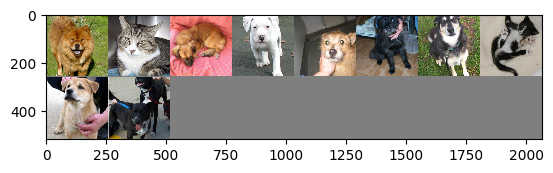

In [17]:
imshow(torchvision.utils.make_grid(images[:10]))
get_labels(labels[:10])

In [46]:
class ImageNet(nn.Sequential):
    
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(
                nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(3*3*64, 10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out


In [47]:
learning_rate = 1.25E-02
model = ImageNet()

In [ ]:
## test the model with 1 batch
with torch.no_grad():
    out = model(images)
    print(out.shape)
    print(labels[:10])
    print(out[:10])

In [49]:
## compute accuracy
def get_accuracy(logit, target):
    ''' Obtain accuracy for training round '''
    # print(logit.argmax(dim=1))
    # print(target)
    corrects = ((logit.argmax(dim=1) == target).float().mean())
    return corrects.item() * 100

In [41]:
get_accuracy(out, labels)

43.75

In [24]:
# find best lr
from torch_lr_finder import LRFinder

# optimizer2 = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
# lr_finder = LRFinder(model, optimizer2, criterion, device=device)
# lr_finder.range_test(train_loader, start_lr=1.0E-03, end_lr=0.1, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset()

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [51]:
def train(model_ref, num_epochs=10):
    for epoch in range(num_epochs):
        train_running_loss = 0.0
        train_acc = 0.0

        model = model_ref.train()

        ## training step
        for i, (images, labels) in enumerate(train_loader):

            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.detach().item()
            train_acc += get_accuracy(logits, labels)

        model.eval()
        print(f'Epoch: {epoch} | Loss: {train_running_loss / i} | Train Accuracy: {train_acc/i}')
    return model


In [52]:
model = train(model, num_epochs=5)

/home/mudro/Documents/Projects/How-to-test-NN/venv/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:850: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 0 | Loss: 0.6500305227744274 | Train Accuracy: 62.5098433250036


/home/mudro/Documents/Projects/How-to-test-NN/venv/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:850: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 1 | Loss: 0.5360541360882612 | Train Accuracy: 73.97301198962407


/home/mudro/Documents/Projects/How-to-test-NN/venv/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:850: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 2 | Loss: 0.4602091900813274 | Train Accuracy: 79.05925342287773


/home/mudro/Documents/Projects/How-to-test-NN/venv/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:850: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 3 | Loss: 0.416333480236622 | Train Accuracy: 81.54029204295232


/home/mudro/Documents/Projects/How-to-test-NN/venv/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:850: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 4 | Loss: 0.3805829332425044 | Train Accuracy: 83.50654150813054


In [54]:
test_acc = 0.0
for i, (images, labels) in enumerate(test_loader):
    with torch.no_grad():
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # print(outputs)
        # print(labels)
        test_acc += get_accuracy(outputs, labels)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 84.32


In [57]:
! pwd

/home/mudro/Documents/Projects/How-to-test-NN/assets


In [73]:
model_save_path = 'model.pt'

In [71]:
torch.save(model.state_dict(), model_save_path)

In [74]:
model_loaded = ImageNet()
model_loaded.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

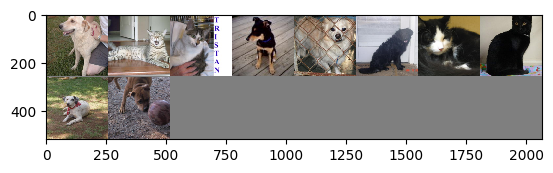

In [76]:
""" Передбачення для рандомного зображення"""
valid_data = iter(valid_loader)
imgs_test, lbls_test = next(valid_data)

imshow(torchvision.utils.make_grid(imgs_test[:10]))

In [77]:
def get_pred(model, image):
    with torch.no_grad:
        image = image.to(device)
        outputs = model(image)
        _, result = torch.max(pred, 1)

    print(f'Predicted {result}.')
    print(f'Predicted {classes[result.item()]}.')
    return classes[result.item()]

In [ ]:
# get random image
from random import randint

idx = randint(0, len(img))
img_to_pred_orig = imgs_test[idx]
img_to_pred = img_to_pred_orig.repeat(3, 1, 1)

imshow(img_to_pred)

### Label
expected = lbls_test[idx]
print(expected)
print(classes[expected.item()])

img_to_tensor = img_to_pred_orig.unsqueeze(0)
img_to_tensor = img_to_tensor.to(device)

pred = model(img_to_tensor)
_, result = torch.max(pred, 1)

print(f'Expected {result}. Predicted is {expected}')
print(f'Expected {classes[result.item()]}. Predicted is {classes[expected.item()]}')